<a href="https://colab.research.google.com/github/JeremyKrick/traffic-trend-predictor/blob/prachi-dev/Final_Project_IOT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import keras
import numpy as np
import matplotlib.pyplot as plt
import os

# Setting seed for reproducibility
np.random.seed(1234)
PYTHONHASHSEED = 0

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from sklearn.model_selection import train_test_split
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM
from keras.layers import Activation
from keras.utils import pad_sequences

In [2]:
from google.colab import drive
drive.mount('/content/drive')
path_uber_15='/content/drive/My Drive/ColabNotebooks/IOT/Final Project/uber-raw-data-janjune-15.csv'

Mounted at /content/drive


In [3]:
df_uber = pd.read_csv(path_uber_15, delimiter = ",")
df_uber.head()

,Dispatching_base_num,Pickup_date,Affiliated_base_num,locationID
0,B02617,2015-05-17 09:47:00,B02617,141
1,B02617,2015-05-17 09:47:00,B02617,65
2,B02617,2015-05-17 09:47:00,B02617,100
3,B02617,2015-05-17 09:47:00,B02774,80
4,B02617,2015-05-17 09:47:00,B02617,90


In [4]:
df_uber.dtypes

Dispatching_base_num    object
Pickup_date             object
Affiliated_base_num     object
locationID               int64
dtype: object

In [5]:
df_uber['Pickup_date']= pd.to_datetime(df_uber['Pickup_date'])

In [7]:
df_uber.dtypes

Dispatching_base_num            object
Pickup_date             datetime64[ns]
Affiliated_base_num             object
locationID                       int64
dtype: object

In [ ]:
df_uber

In [8]:
df_uber.head()

,Dispatching_base_num,Pickup_date,Affiliated_base_num,locationID
0,B02617,2015-05-17 09:47:00,B02617,141
1,B02617,2015-05-17 09:47:00,B02617,65
2,B02617,2015-05-17 09:47:00,B02617,100
3,B02617,2015-05-17 09:47:00,B02774,80
4,B02617,2015-05-17 09:47:00,B02617,90


In [9]:
#use datetime_is_numeric = True to get statistics on the datetime column
desc = df_uber.describe(datetime_is_numeric = True)

#force the printout not to use scientific notation
#desc[desc.columns[:-1]] = desc[desc.columns[:-1]].apply(lambda x: x.apply("{0:.4f}".format))
desc

,Pickup_date,locationID
count,14270479,1.427048e+07
mean,2015-04-07 15:04:13.657453056,1.520574e+02
min,2015-01-01 00:00:05,1.000000e+00
25%,2015-02-21 03:00:16.500000,9.200000e+01
50%,2015-04-10 16:21:00,1.570000e+02
75%,2015-05-23 03:53:00,2.300000e+02
max,2015-06-30 23:59:00,2.650000e+02
std,NaN,7.159620e+01


<Axes: >

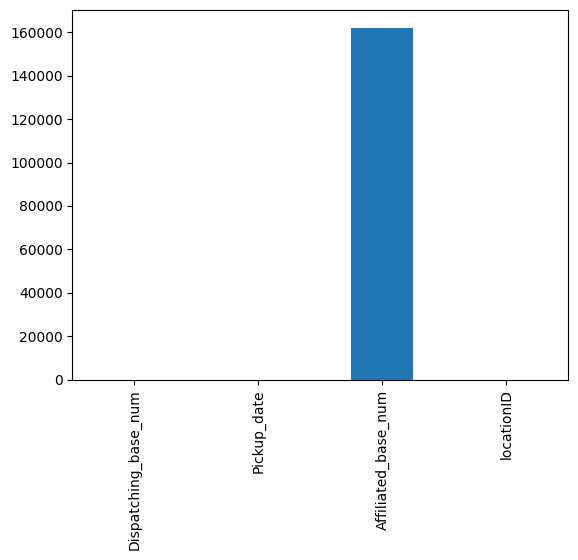

In [11]:
df_uber.isna().sum().plot.bar()

In [12]:
df_uber = df_uber.dropna()

<Axes: >

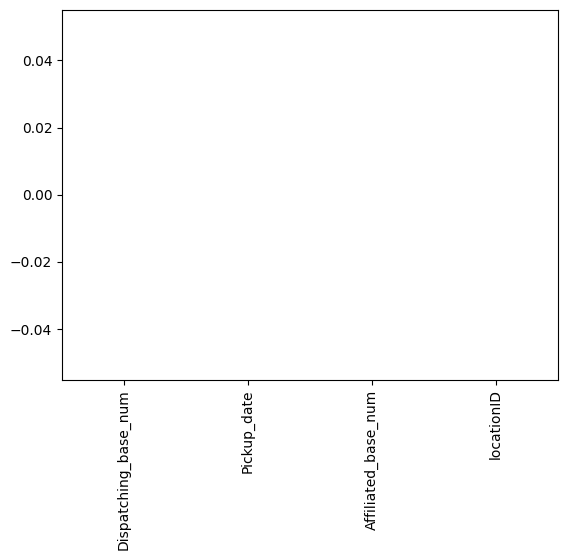

In [13]:
df_uber.isna().sum().plot.bar()

In [14]:
df_uber.duplicated().sum()

896732

In [15]:
df_uber.drop_duplicates(inplace=True)

In [16]:
df_uber.duplicated().sum()

0

In [17]:
df_uber.shape

(13211552, 4)

In [18]:
df_uber["month"] = df_uber["Pickup_date"].dt.month_name()
df_uber["weekday"] = df_uber["Pickup_date"].dt.day_name()

In [19]:
df_uber.head()

,Dispatching_base_num,Pickup_date,Affiliated_base_num,locationID,month,weekday
0,B02617,2015-05-17 09:47:00,B02617,141,May,Sunday
1,B02617,2015-05-17 09:47:00,B02617,65,May,Sunday
2,B02617,2015-05-17 09:47:00,B02617,100,May,Sunday
3,B02617,2015-05-17 09:47:00,B02774,80,May,Sunday
4,B02617,2015-05-17 09:47:00,B02617,90,May,Sunday


In [22]:
df_uber["month"].value_counts()

June        2571771
May         2483980
February    2141306
April       2112705
March       2062639
January     1839151
Name: month, dtype: int64

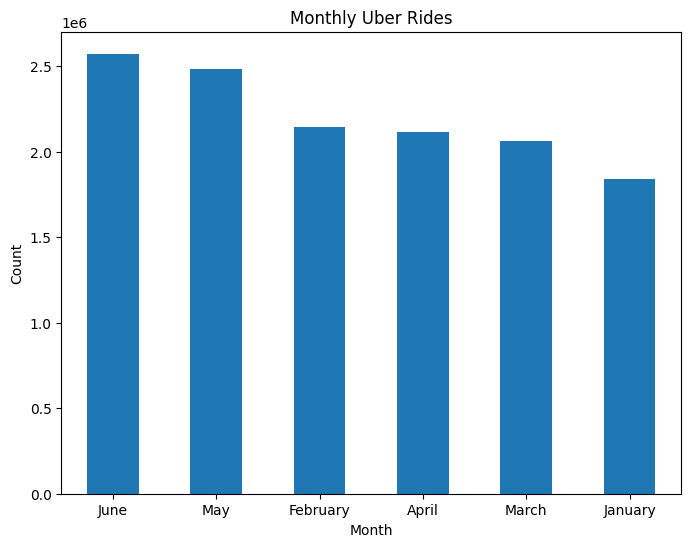

In [23]:
import matplotlib.pyplot as plt

# Plot data
counts = df_uber["month"].value_counts()
plt.figure(figsize=(8, 6))  # Set the figure size
counts.plot(kind="bar")  # Use skyblue color
plt.xlabel("Month")  # X-axis label
plt.ylabel("Count")  # Y-axis label
plt.title("Monthly Uber Rides")  # Plot title
plt.xticks(rotation=0)  # Set X-axis label rotation

# Show the plot
plt.show()

In [25]:
pivot = pd.crosstab(index=df_uber["month"], columns=df_uber["weekday"])
pivot

weekday,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
month,,,,,,,
April,315002,238429,324545,273560,372522,250632,338015
February,360136,264693,354962,284432,323955,276956,276172
January,325261,182785,369693,219884,316857,188802,235869
June,371225,375312,399377,334434,357782,405500,328141
March,309631,269931,314785,313865,277026,320634,256767
May,430134,255501,464298,390391,337607,290004,316045


<Figure size 800x600 with 0 Axes>

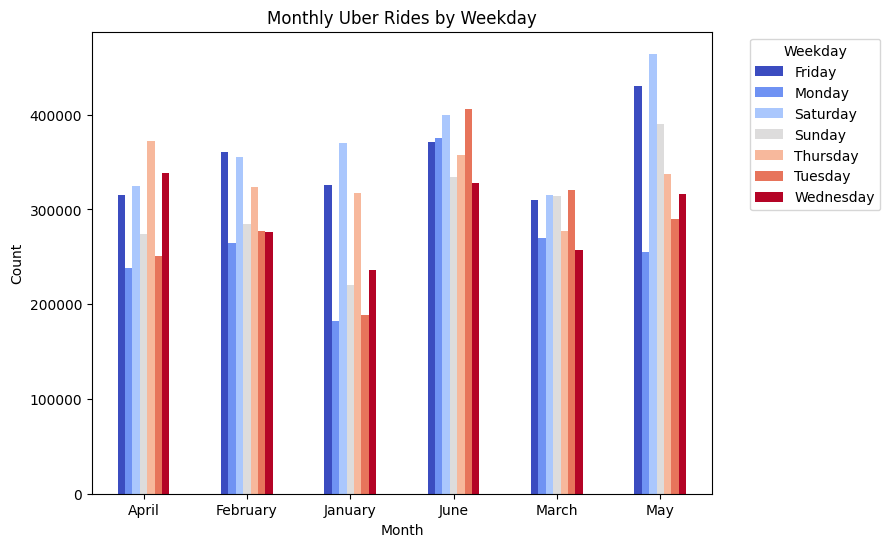

In [26]:
plt.figure(figsize=(8, 6))  # Set the figure size
pivot.plot(kind="bar", figsize=(8, 6), cmap='coolwarm')  # Use a coolwarm color palette
plt.xlabel("Month")  # X-axis label
plt.ylabel("Count")  # Y-axis label
plt.title("Monthly Uber Rides by Weekday")  # Plot title
plt.xticks(rotation=0)  # Set X-axis label rotation

# Show the plot
plt.legend(title="Weekday", bbox_to_anchor=(1.05, 1), loc='upper left')  # Add legend
plt.show()

In [27]:
df_uber['hour'] = df_uber['Pickup_date'].dt.hour

In [28]:
summary = df_uber.groupby(['weekday', 'hour'], as_index=False).size()
summary

,weekday,hour,size
0,Friday,0,78936
1,Friday,1,44064
2,Friday,2,26942
3,Friday,3,18845
4,Friday,4,22798
...,...,...,...
163,Wednesday,19,129724
164,Wednesday,20,122022
165,Wednesday,21,119511
166,Wednesday,22,113909


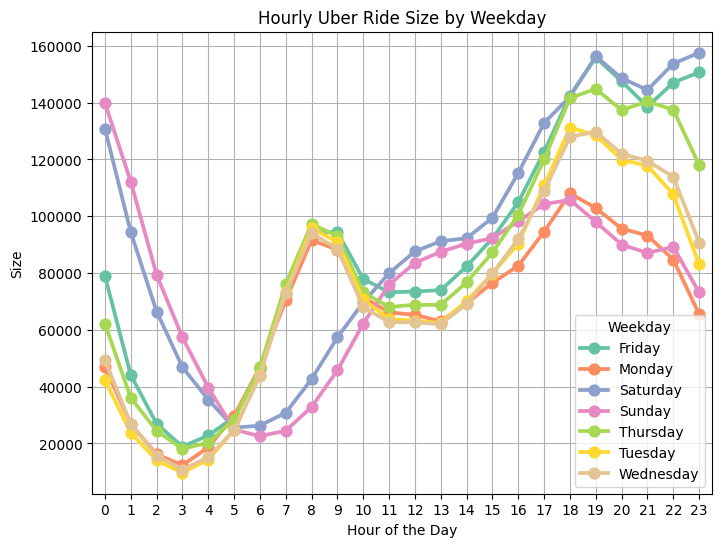

In [29]:
import seaborn as sns

# Set the figure size
plt.figure(figsize=(8, 6))

# Create the point plot
sns.pointplot(x="hour", y="size", hue="weekday", data=summary, palette="Set2")

# Add labels and title
plt.xlabel("Hour of the Day")
plt.ylabel("Size")
plt.title("Hourly Uber Ride Size by Weekday")

# Customize the legend
plt.legend(title="Weekday")

# Show the plot
plt.grid(True)  # Add grid lines
plt.show()